# Assimilation of TBs to correct TOPAZ5 forecasts
- Standalone analysis using the EnKF-C software
- Model data: TOPAZ5 outputs
- Observations: sea-ice concentration (SIT) and Tbs (19v, 19h, 37v, 37h) from AMSR2 

## Four data assimilation experiments are defined. Experiments are to be performed in this order:
1. exp_sic: synchronous assimilation of SIC
2. exp_tb: synchronous assimilation of Tbs
3. exp_sic_asyn: asynchronous assimilation of SIC
4. exp_tb_asyn: asynchronous assimilation of Tbs

## This notebook is composed of five steps:
1. Computation of DAL and 2D-plane coefficients
2. RTM Tbs simulation
3. Preparation of background ensemble, observations and mask for EnKF
4. Run EnKF
5. Plotting

In [1]:
import importlib
from steps_da.main_imports import cmd

In [2]:
config_filename = 'config_2021.py'
cmd(f'cp {config_filename} config.py')
import config; importlib.reload(config)

cp config_2021.py config.py


<module 'config' from '/home/marinadm/rtm_da/config.py'>

In [3]:
cmd(f'rm {config.exps_dir}/conf/mask_topaz5.nc')
cmd(f'ln -s {config.exps_dir}/conf/{config.date[0:4]}/topaz5_grid_{config.date[0:4]}.nc  {config.exps_dir}/conf/mask_topaz5.nc')

rm /lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/conf/mask_topaz5.nc
ln -s /lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/conf/2021/topaz5_grid_2021.nc  /lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/conf/mask_topaz5.nc


0

In [4]:
print("DA experiment: ", config.assim)

DA experiment:  exp_tb_asyn


## Define the steps to perform

In [5]:
run_all_steps = True 
if run_all_steps: compute_coeffs = run_rtm = prepare_enkf = run_enkf = make_plots = True
else :
    compute_coeffs = False 
    run_rtm = False 
    prepare_enkf = False
    run_enkf = True 
    make_plots = True 

## Step 1: Computation of DAL and 2D-plane coefficients

In [6]:
if compute_coeffs :
    
    from rtm_dal.main_fcts_rtm_tbs import *

    print('Computation of DAL (Distance Along the Line) from TPD and TPA files...')
    dal_norm, _, list_tpd_files = compute_dal() 

    print('\nComputation of 2D-plane coefficients. This 2D-plane is defined by the relation between Emissivity, DAL and T2M...')
    compute_coeffs(dal_norm, list_tpd_files)  
    
    print('...computation finished.')

Computation of DAL (Distance Along the Line) from TPD and TPA files

Computation of 2D-plane coefficients. This 2D-plane is defined by the relation between Emissivity, DAL and T2M


## Step 2: RTM TBs simulation

In [7]:
if run_rtm :
    
    from rtm_dal.main_fcts_rtm_tbs import *
    
    if 'exp_tb_asyn' in config.assim :
        
        print('\nComputation of RTM Tbs (swaths)...')
        import warnings
        warnings.filterwarnings("ignore") # Ignore warning related to division in eq35
        res = run_rtm_swaths(version = 1)
        warnings.resetwarnings()        

        print('\nCreate directory where RTM Tbs will be saved')
        cmd('mkdir -p ' + f"{config.rtm_tbs_dir}"); cmd('mkdir -p ' + f"{config.rtm_tbs_dir}/passes/")

        print('\nCreate netCDF files containing RTM Tbs and saved them in the previously defined directory')
        save_rtm_tbs(res[0], f"{config.rtm_tbs_dir}/passes/", swaths = True)
        
    elif 'exp_sic' in config.assim :
        
        print('\nComputation of RTM Tbs (daily means)')
        import warnings
        warnings.filterwarnings("ignore") # Ignore warning related to division in eq35
        res = run_rtm(version = 1) 
        warnings.resetwarnings()        

        print('\nCreate directory where RTM Tbs will be saved')
        cmd('mkdir -p ' + f"{config.rtm_tbs_dir}"); cmd('mkdir -p ' + f"{config.rtm_tbs_dir}/means/")

        print('\nCreate netCDF files containing RTM Tbs and saved them in the previously defined directory')
        save_rtm_tbs(res[0], f"{config.rtm_tbs_dir}/means/")
    
    print('...RTM simulation finished.')


Computation of RTM Tbs (swaths)...
Computing Tbs for member m001, channel 19v...
Computing Tbs for member m002, channel 19v...
Computing Tbs for member m003, channel 19v...
Computing Tbs for member m004, channel 19v...
Computing Tbs for member m005, channel 19v...
Computing Tbs for member m006, channel 19v...
Computing Tbs for member m007, channel 19v...
Computing Tbs for member m008, channel 19v...
Computing Tbs for member m009, channel 19v...
Computing Tbs for member m010, channel 19v...
Computing Tbs for member m001, channel 19h...
Computing Tbs for member m002, channel 19h...
Computing Tbs for member m003, channel 19h...
Computing Tbs for member m004, channel 19h...
Computing Tbs for member m005, channel 19h...
Computing Tbs for member m006, channel 19h...
Computing Tbs for member m007, channel 19h...
Computing Tbs for member m008, channel 19h...
Computing Tbs for member m009, channel 19h...
Computing Tbs for member m010, channel 19h...
Computing Tbs for member m001, channel 37v..

## Step 3: Preparation of background ensemble, observations and mask for EnKF

In [8]:
if prepare_enkf :
    
    print('Preparation of background ensemble, observations and mask for EnKF-C')
    cmd('mkdir -p ' + config.storage_dir)
    cmd('mkdir -p ' + config.storage_dir + 'ensb');
    cmd('rm ' + config.storage_dir + 'ensb/*nc')

    if config.assim == 'exp_sic' :
        
        from steps_da import prepare_ens; importlib.reload(prepare_ens); prep_ens = prepare_ens.prep_ensemble        
        from steps_da import prepare_obs; importlib.reload(prepare_obs); prep_topaz = prepare_obs.prep_topaz        
        from steps_da import model_mask; importlib.reload(model_mask); prep_mask = model_mask.generate_mask
        
        print('Ensemble preparation...'); prep_ens()        
        print('Prepare observations (means)...'); prep_topaz()        
        print('Generation of TOPAZ mask...'); prep_mask() 

    elif config.assim == 'exp_tb' :      
        
        storage_dir_tbs = f"{config.exps_dir}/exps_2021/exp_sic/{config.date}/"
        cmd('ln -s ' + storage_dir_tbs + 'ensb/* ' + config.storage_dir + 'ensb/') # Link to background ensemble
        
    elif config.assim == 'exp_sic_asyn' :
        
        storage_dir_asyn = f"{config.exps_dir}/exps_2021/exp_sic/{config.date}/"
        cmd('ln -s ' + storage_dir_asyn + 'ensb/* ' + config.storage_dir + 'ensb/') # Link to background ensemble
        
        from steps_da import prepare_ens; importlib.reload(prepare_ens); prep_ens = prepare_ens.prep_ensemble_asyn
        from steps_da import prepare_obs; importlib.reload(prepare_obs); prep_topaz = prepare_obs.prep_topaz_passes
        from steps_da import change_date; importlib.reload(change_date); update = change_date.update_enkf_prm
        
        print('Ensemble preparation for ASYN experiment...'); prep_ens()        
        print('Prepare observations (passes)...'); prep_topaz()
        print('Update the EnKF date...'); update()
        
    elif config.assim == 'exp_tb_asyn' : 
        
        storage_dir_asyn = f"{config.exps_dir}/exps_2021/exp_sic/{config.date}/"
        cmd('ln -s ' + storage_dir_asyn + 'ensb/* ' + config.storage_dir + 'ensb/') # Link to background ensemble
        
        from steps_da import prepare_ens; importlib.reload(prepare_ens); prep_ens = prepare_ens.prep_ensemble_asyn
        
        print('Ensemble preparation for ASYN experiment...'); prep_ens()   

    print('...preparation of model and observation data finished.')

Preparation of background ensemble, observations and mask for EnKF-C
mkdir -p /lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201/
mkdir -p /lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201/ensb
rm /lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201/ensb/*nc
ln -s /lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_sic/20211201/ensb/* /lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201/ensb/
Ensemble preparation for ASYN experiment


/home/marinadm/rtm_da/steps_da/prepare_ens.py:133: RuntimeWarning: Mean of empty slice
  var_inn = np.nanmean(m_tbs[ich, (i - 1)*6:(i - 1)*6 + 6, :, :], axis = 0)


/lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201//ensb/mem001_tb19v_-4.nc
/lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201//ensb/mem001_tb19h_-4.nc
/lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201//ensb/mem001_tb37v_-4.nc
/lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201//ensb/mem001_tb37h_-4.nc
/lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201//ensb/mem001_tb19v_-3.nc
/lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201//ensb/mem001_tb19h_-3.nc
/lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201//ensb/mem001_tb37v_-3.nc
/lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201//ensb/mem001_tb37h_-3.nc
/lustre/storeB/project/fou/fd/project/ac

## Step 4: Run EnKF

In [9]:
if run_enkf :
    
    cmd('module use /modules/MET/rhel8/user-modules/')
    cmd('module load enkfc/2.9.9') 

    print('Running EnKF-C...')
    from steps_da.run_da import run_enkf
    run_enkf()
    
    print('...run finished.')

module use /modules/MET/rhel8/user-modules/
module load enkfc/2.9.9
Loading enkfc/2.9.9
  Loading requirement: fou-modules/hdf5/1.13.1
    /modules/MET/rhel8/user-modules/fou-kl/hdf5/1.13.1 fou-modules/netcdf/4.9.0
    openmpi/4.1.4-gcc
Running EnKF-C...
rm /lustre/storeB/users/marinadm/enkf_run/acciberg/exp_tb_asyn/ensemble_100/*
rm /lustre/storeB/users/marinadm/enkf_run/acciberg/exp_tb_asyn/obs/*
rm /lustre/storeB/users/marinadm/enkf_run/acciberg/exp_tb_asyn/conf/mask_topaz_tbs.nc
make clean
cp  /lustre/storeB/users/marinadm/enkf_run/acciberg/2021_prm_files/exp_tb_asyn/*prm /lustre/storeB/users/marinadm/enkf_run/acciberg/exp_tb_asyn/


cp: cannot stat '/lustre/storeB/users/marinadm/enkf_run/acciberg/2021_prm_files/exp_tb_asyn/*prm': No such file or directory


Command failed: 1
ln -s /lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/observations/passes/amsr2_topaz_obs_20211201*.nc /lustre/storeB/users/marinadm/enkf_run/acciberg/exp_tb_asyn/obs/
ln -s /lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201/ensb/* /lustre/storeB/users/marinadm/enkf_run/acciberg/exp_tb_asyn/ensemble_100/
ln -s /lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/conf/mask_topaz5.nc /lustre/storeB/users/marinadm/enkf_run/acciberg/exp_tb_asyn/conf/


ln: failed to create symbolic link '/lustre/storeB/users/marinadm/enkf_run/acciberg/exp_tb_asyn/conf/mask_topaz5.nc': File exists


Command failed: 1
ln -s /lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/conf/mask_topaz_tbs.nc /lustre/storeB/users/marinadm/enkf_run/acciberg/exp_tb_asyn/conf/
make
#cp /home/marinadm/enkf-c-master/enkf/bin/enkf_prep .
cp /modules/rhel8/user-apps/enkfc/2.9.9/bin/enkf_prep .
#cp `which enkf_prep` .
./enkf_prep enkf.prm 2>&1 | tee prep.out
  running PREP for EnKF-C version 2.9.9:
    command = "./enkf_prep enkf.prm"
    dir = "/lustre/storeB/users/marinadm/enkf_run/acciberg/exp_tb_asyn"
  2024-12-03 12:43:59
  reading prep specs from "enkf.prm":
    MODE = EnKF
    SCHEME = DEnKF
    MODEL PRM = "model.prm"
    GRID PRM = "grid.prm"
    OBS TYPES PRM = "obstypes.prm"
    OBS PRM = "obs.prm"
    DATE = "12188 days since 1990-01-01"
    ENSEMBLE DIR = "ensemble_100"
    ENSEMBLE SIZE = 10
    RFACTOR BASE = 1.0
    INFLATION BASE = 1.2000
    INFLATION MODE = CAPPED, MAX RATIO = 1.00
    KFACTOR = 2.0
      LOCRAD  = 20
      LOCWEIGHT =  1
    STRIDE = 3
    FIELDBUFFERSI

mkdir: cannot create directory ‘/lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201/enkf_files’: File exists


Command failed: 1
cp /lustre/storeB/users/marinadm/enkf_run/acciberg/exp_tb_asyn/enkf_diag*nc /lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201/enkf_files
cp /lustre/storeB/users/marinadm/enkf_run/acciberg/exp_tb_asyn/observations.nc /lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201/enkf_files
cp /lustre/storeB/users/marinadm/enkf_run/acciberg/exp_tb_asyn/spread.nc /lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201/enkf_files
cp /lustre/storeB/users/marinadm/enkf_run/acciberg/exp_tb_asyn/*prm /lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201/enkf_files
cp /lustre/storeB/users/marinadm/enkf_run/acciberg/exp_tb_asyn/*out /lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201/enkf_files
...run finished.


## Step 5: Plotting

Making figures for variable aice_d...
mem001
/lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201//ensb/mem001_aice_d.nc
mem002
/lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201//ensb/mem002_aice_d.nc
mem003
/lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201//ensb/mem003_aice_d.nc
mem004
/lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201//ensb/mem004_aice_d.nc
mem005
/lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201//ensb/mem005_aice_d.nc
mem006
/lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201//ensb/mem006_aice_d.nc
mem007
/lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb_asyn/20211201//ensb/mem007_aice_d.nc
mem008
/lustre/storeB/project/fou/fd/project/acciberg/marina/enkf_exps/exps_2021/exp_tb

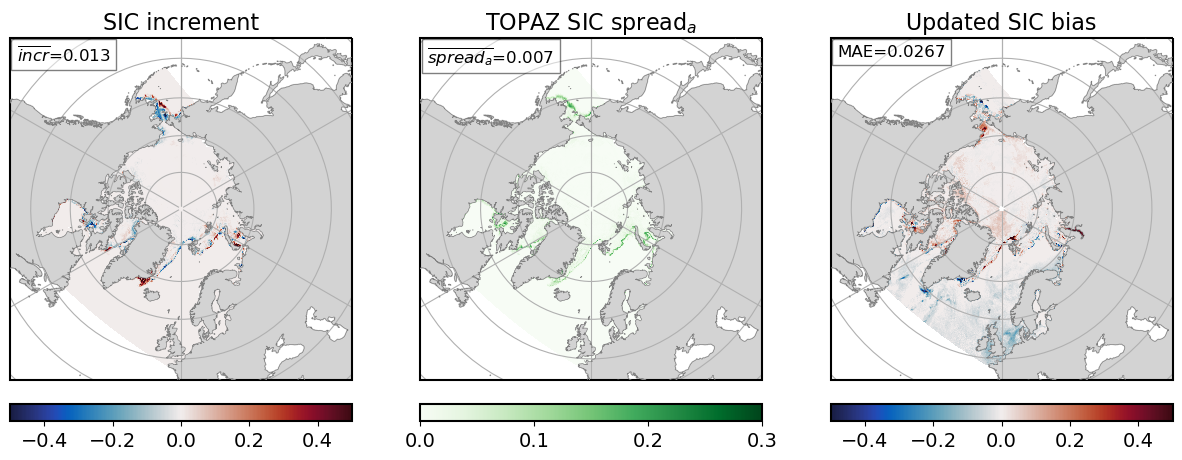

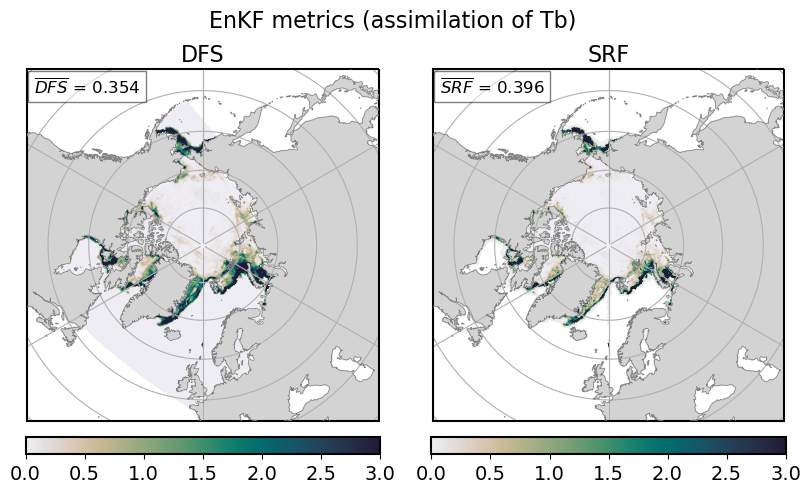

In [14]:
'''
 vari = 0 is aice
 vari = 1 is hi
 vari = 8 is iage
'''

vari = 0
metrics = True

if make_plots :
    
    print(f'Making figures for variable {config.varnames[vari]}...')
    from steps_da.plotting import *
    from steps_da import plotting
    importlib.reload(plotting)
    plot_metrics = plotting.plot_metrics
    
    if config.assim == 'exp_sic' :
        if vari == 0 :
            background_maps()
            background_maps(var = 'tb', var_tb = 0)
            analysis_maps(vari)
        elif vari > 0 : no_obs_maps(vari)

    else :
        if vari == 0 :
            analysis_maps(vari)
        elif vari > 0 : no_obs_maps(vari)
        
    if metrics : 
        
        print('\nPlotting EnKF metrics (DFS and SRF)...')
        plot_metrics()
        
    print('...plotting finished.')